In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Replace 'fr1-xyz.tgz' with the exact filename if it's different
!cp /content/drive/MyDrive/rgbd_dataset_freiburg1_xyz.tgz /content/
# -x: extract, -z: decompress, -v: verbose (show files), -f: from file
!tar -xzvf /content/rgbd_dataset_freiburg1_xyz.tgz


rgbd_dataset_freiburg1_xyz/
rgbd_dataset_freiburg1_xyz/accelerometer.txt
rgbd_dataset_freiburg1_xyz/rgb/
rgbd_dataset_freiburg1_xyz/rgb/1305031107.143260.png
rgbd_dataset_freiburg1_xyz/rgb/1305031125.650575.png
rgbd_dataset_freiburg1_xyz/rgb/1305031106.711508.png
rgbd_dataset_freiburg1_xyz/rgb/1305031119.747193.png
rgbd_dataset_freiburg1_xyz/rgb/1305031114.211303.png
rgbd_dataset_freiburg1_xyz/rgb/1305031103.743326.png
rgbd_dataset_freiburg1_xyz/rgb/1305031124.249327.png
rgbd_dataset_freiburg1_xyz/rgb/1305031103.543444.png
rgbd_dataset_freiburg1_xyz/rgb/1305031124.850535.png
rgbd_dataset_freiburg1_xyz/rgb/1305031105.211268.png
rgbd_dataset_freiburg1_xyz/rgb/1305031110.311404.png
rgbd_dataset_freiburg1_xyz/rgb/1305031107.343509.png
rgbd_dataset_freiburg1_xyz/rgb/1305031112.043270.png
rgbd_dataset_freiburg1_xyz/rgb/1305031107.411271.png
rgbd_dataset_freiburg1_xyz/rgb/1305031120.315196.png
rgbd_dataset_freiburg1_xyz/rgb/1305031106.075330.png
rgbd_dataset_freiburg1_xyz/rgb/1305031114.57923

In [5]:
!pip install -q kornia kornia_rs opencv-python matplotlib tqdm transformers

--- Step 1: Environment setup complete ---

--- Step 2: Defining helper functions for data and evaluation ---

--- Step 3: Initializing LoFTR model and preparing data ---
Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to /root/.cache/torch/hub/checkpoints/loftr_outdoor.ckpt


100%|██████████| 44.2M/44.2M [00:03<00:00, 15.0MB/s]


LoFTR model loaded successfully.
Loading and associating RGB, Depth, and Ground Truth data...
Found 798 associated RGB-Depth image pairs for odometry.

--- Step 4: Running Visual Odometry using LoFTR ---


LoFTR Odometry:   0%|          | 0/797 [00:00<?, ?it/s]


--- Step 5: Evaluating LoFTR trajectory against official ground truth ---


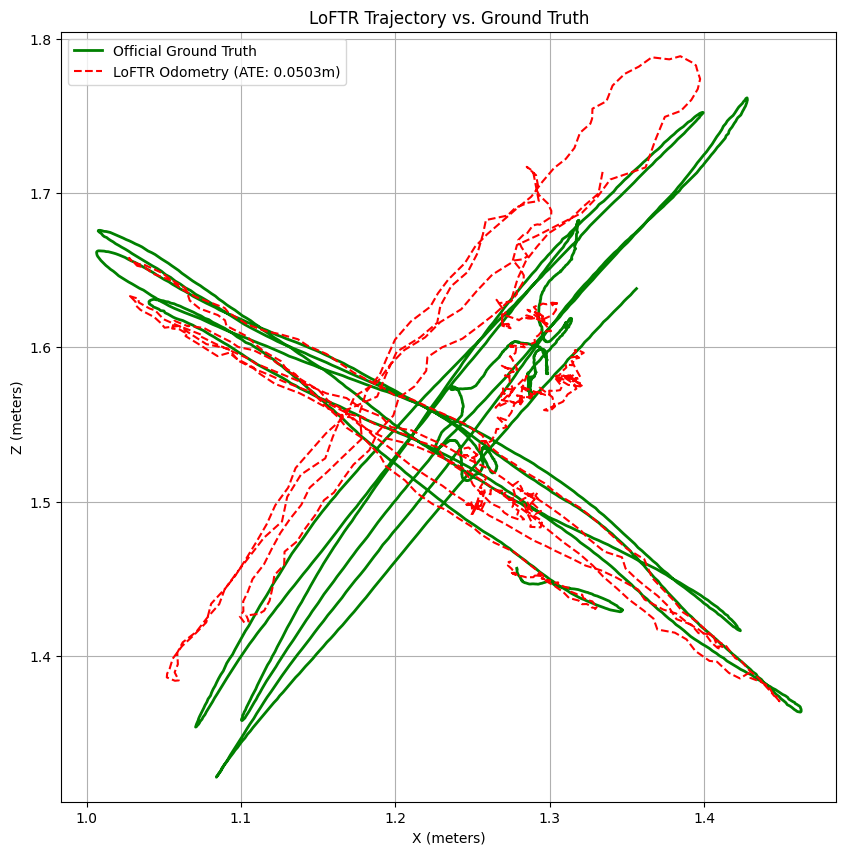


     LoFTR PERFORMANCE BENCHMARK
Metric: Absolute Trajectory Error (ATE) RMSE
Lower is better.

LoFTR-based Visual Odometry: 0.0503 meters


In [4]:
# ==============================================================================
# STEP 1: SETUP AND IMPORTS
# ==============================================================================
# Install Kornia for LoFTR and other necessary libraries


import os
import numpy as np
import torch
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

print("--- Step 1: Environment setup complete ---")

# ==============================================================================
# STEP 2: DEFINE HELPER FUNCTIONS
# ==============================================================================
print("\n--- Step 2: Defining helper functions for data and evaluation ---")

### --- Functions for TUM Dataset Association --- ###
def read_file_list(filename):
    """Reads a TUM-format file and returns a list of (timestamp, data) tuples."""
    with open(filename) as file:
        data = file.read()
        lines = data.replace(",", " ").replace("\t", " ").split("\n")
        lines = [line for line in lines if not line.startswith('#') and len(line) > 0]
        # For ground truth, data is [tx, ty, tz, qx, qy, qz, qw]
        if len(lines[0].split()) > 2:
            return [(float(line.split()[0]), [float(v) for v in line.split()[1:]]) for line in lines]
        # For rgb/depth, data is just the path
        else:
            return [(float(line.split()[0]), line.split()[1]) for line in lines]

def associate(first_list, second_list, max_difference=0.02):
    """Associates two lists of (timestamp, data) tuples based on closest timestamp."""
    first_dict = dict(first_list)
    second_dict = dict(second_list)
    matches = []
    for ts, data1 in first_list:
        best_match_ts = min(second_dict.keys(), key=lambda t: abs(t - ts))
        if abs(best_match_ts - ts) < max_difference:
            matches.append((ts, data1, best_match_ts, second_dict[best_match_ts]))
    return matches

### --- Functions for Evaluation --- ###
def align_trajectory(estimated_poses, gt_poses):
    """Aligns two trajectories using Umeyama's algorithm."""
    est_centroid = np.mean(estimated_poses, axis=0)
    gt_centroid = np.mean(gt_poses, axis=0)
    est_centered = estimated_poses - est_centroid
    gt_centered = gt_poses - gt_centroid
    H = est_centered.T @ gt_centered
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
    t = gt_centroid - (R @ est_centroid)
    aligned_poses = (R @ estimated_poses.T).T + t
    return aligned_poses

def calculate_ate(aligned_poses, gt_poses):
    """Calculates the Absolute Trajectory Error (ATE) as RMSE."""
    errors = aligned_poses - gt_poses
    return np.sqrt(np.mean(np.sum(errors**2, axis=1)))

# ==============================================================================
# STEP 3: INITIALIZE MODEL AND PREPARE DATA
# ==============================================================================
print("\n--- Step 3: Initializing LoFTR model and preparing data ---")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_PATH = 'rgbd_dataset_freiburg1_xyz/'
DEPTH_SCALING_FACTOR = 5000.0
CAMERA_INTRINSICS = np.array([[517.3, 0, 318.6], [0, 516.5, 255.3], [0, 0, 1]], dtype=np.float32)

# --- Load LoFTR Model ---
loftr = KF.LoFTR(pretrained='outdoor').to(DEVICE).eval()
print("LoFTR model loaded successfully.")

# --- Load and Associate Data ---
print("Loading and associating RGB, Depth, and Ground Truth data...")
rgb_list = read_file_list(os.path.join(DATASET_PATH, 'rgb.txt'))
depth_list = read_file_list(os.path.join(DATASET_PATH, 'depth.txt'))
gt_list = read_file_list(os.path.join(DATASET_PATH, 'groundtruth.txt'))
matches_rgb_depth = associate(rgb_list, depth_list)
print(f"Found {len(matches_rgb_depth)} associated RGB-Depth image pairs for odometry.")

# ==============================================================================
# STEP 4: RUN VISUAL ODOMETRY WITH LoFTR
# ==============================================================================
print("\n--- Step 4: Running Visual Odometry using LoFTR ---")

R_total = np.eye(3)
T_total = np.zeros((3, 1))
trajectory_loftr = {matches_rgb_depth[0][0]: T_total.flatten()} # Store poses with timestamps

for i in tqdm(range(len(matches_rgb_depth) - 1), desc="LoFTR Odometry"):
    # 1. Load data for two consecutive frames
    ts1, rgb_path1, _, depth_path1 = matches_rgb_depth[i]
    ts2, rgb_path2, _, _ = matches_rgb_depth[i+1]

    img0_bgr = cv2.imread(os.path.join(DATASET_PATH, rgb_path1))
    img1_bgr = cv2.imread(os.path.join(DATASET_PATH, rgb_path2))
    depth_raw = cv2.imread(os.path.join(DATASET_PATH, depth_path1), cv2.IMREAD_UNCHANGED)
    if img0_bgr is None or img1_bgr is None or depth_raw is None: continue

    # 2. Prepare images for LoFTR (Grayscale, Tensor, Batch dimension)
    img0_gray_tensor = K.image_to_tensor(cv2.cvtColor(img0_bgr, cv2.COLOR_BGR2GRAY), False).float() / 255.
    img1_gray_tensor = K.image_to_tensor(cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2GRAY), False).float() / 255.
    input_dict = {"image0": img0_gray_tensor.to(DEVICE), "image1": img1_gray_tensor.to(DEVICE)}

    # 3. Perform LoFTR matching
    with torch.no_grad():
        correspondences = loftr(input_dict)

    # 4. Filter matches based on confidence
    conf = correspondences['confidence'].cpu().numpy()
    good_matches_mask = conf > 0.9  # Confidence threshold
    if good_matches_mask.sum() < 10: continue

    mkpts0 = correspondences['keypoints0'].cpu().numpy()[good_matches_mask]
    mkpts1 = correspondences['keypoints1'].cpu().numpy()[good_matches_mask]

    # 5. Get 3D points from depth map for the first frame's keypoints
    depth_map = depth_raw.astype(np.float32) / DEPTH_SCALING_FACTOR
    pts_3d_cam1, pts_2d_img2_filtered = [], []
    for pt0, pt1 in zip(mkpts0, mkpts1):
        x, y = int(pt0[0]), int(pt0[1])
        if 0 <= y < depth_map.shape[0] and 0 <= x < depth_map.shape[1]:
            d = depth_map[y, x]
            if d > 0.1: # Filter out invalid depth
                X = (x - CAMERA_INTRINSICS[0, 2]) * d / CAMERA_INTRINSICS[0, 0]
                Y = (y - CAMERA_INTRINSICS[1, 2]) * d / CAMERA_INTRINSICS[1, 1]
                pts_3d_cam1.append([X, Y, d])
                pts_2d_img2_filtered.append(pt1)

    if len(pts_3d_cam1) < 10: continue

    # 6. Estimate pose with solvePnP
    success, rvec, tvec, _ = cv2.solvePnPRansac(
        np.array(pts_3d_cam1), np.array(pts_2d_img2_filtered), CAMERA_INTRINSICS, None
    )
    if not success or rvec is None: continue

    # 7. Accumulate odometry
    R, _ = cv2.Rodrigues(rvec)
    R_inv, t_inv = R.T, -R.T @ tvec
    T_total = T_total + R_total @ t_inv
    R_total = R_inv @ R_total
    trajectory_loftr[ts2] = T_total.flatten()

# ==============================================================================
# STEP 5: EVALUATE AND VISUALIZE
# ==============================================================================
print("\n--- Step 5: Evaluating LoFTR trajectory against official ground truth ---")

# --- Associate estimated trajectory with ground truth for scoring ---
gt_poses_dict = dict(gt_list)
est_loftr_matches = associate(list(trajectory_loftr.items()), list(gt_poses_dict.items()))

# --- Prepare pose arrays for alignment and ATE calculation ---
poses_loftr_est = np.array([match[1] for match in est_loftr_matches])
poses_loftr_true = np.array([match[3][:3] for match in est_loftr_matches]) # Only tx, ty, tz

# --- Align trajectory and calculate ATE ---
aligned_loftr_traj = align_trajectory(poses_loftr_est, poses_loftr_true)
ate_loftr = calculate_ate(aligned_loftr_traj, poses_loftr_true)

# --- Prepare full ground truth trajectory for plotting ---
gt_traj_full = np.array([v[:3] for _, v in gt_list])

# --- Plot the trajectories ---
plt.figure(figsize=(10, 10))
plt.plot(gt_traj_full[:, 0], gt_traj_full[:, 2], 'g-', label='Official Ground Truth', linewidth=2)
plt.plot(aligned_loftr_traj[:, 0], aligned_loftr_traj[:, 2], 'r--', label=f'LoFTR Odometry (ATE: {ate_loftr:.4f}m)')
plt.title('LoFTR Trajectory vs. Ground Truth')
plt.xlabel('X (meters)')
plt.ylabel('Z (meters)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# --- Print Final Numerical Result ---
print("\n" + "="*40)
print("     LoFTR PERFORMANCE BENCHMARK")
print("="*40)
print("Metric: Absolute Trajectory Error (ATE) RMSE")
print("Lower is better.\n")
print(f"LoFTR-based Visual Odometry: {ate_loftr:.4f} meters")
print("="*40)

--- Step 1: Environment setup complete ---

--- Step 2: Defining helper functions for data, models, and evaluation ---

--- Step 3: Initializing models and preparing all data sources ---
Loading ZoeDepth model 'Intel/zoedepth-nyu-kitti'...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

All models loaded successfully.
Loading and associating RGB, Depth, and Ground Truth data...
Found 798 associated RGB-Depth image pairs.


LoFTR + GT Depth:   0%|          | 0/797 [00:00<?, ?it/s]

LoFTR + ZoeDepth:   0%|          | 0/797 [00:00<?, ?it/s]


--- Step 6: Evaluating trajectories against official ground truth ---


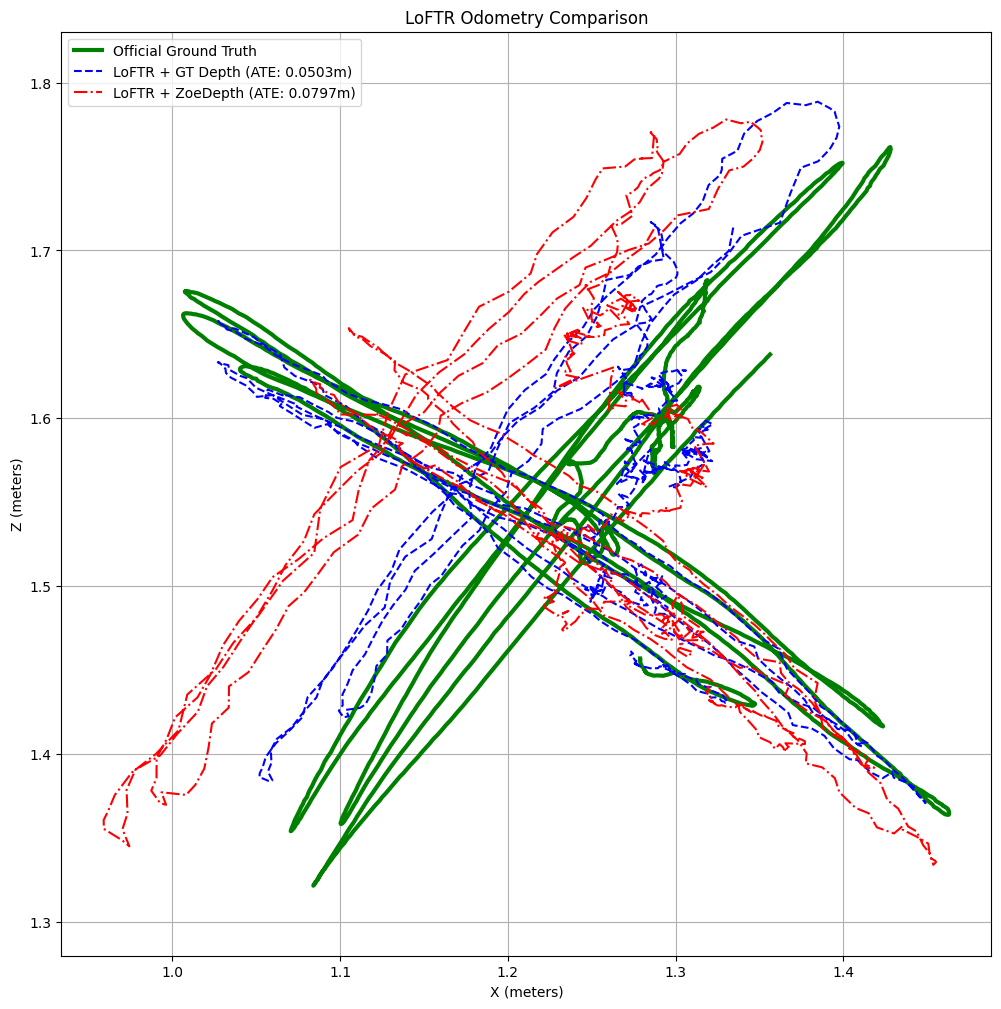


         LoFTR PERFORMANCE COMPARISON
Metric: Absolute Trajectory Error (ATE) RMSE
Lower is better.

LoFTR + Ground Truth Depth: 0.0503 meters
LoFTR + ZoeDepth Prediction:  0.0797 meters
--------------------------------------------------
The performance difference is only 2.94 cm.
🏆 Result: Using the dataset's depth sensor was slightly more accurate.


In [6]:
# ==============================================================================
# STEP 1: SETUP AND IMPORTS
# ==============================================================================
# Install Kornia for LoFTR and other necessary libraries


import os
import numpy as np
import torch
import cv2
from PIL import Image
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

print("--- Step 1: Environment setup complete ---")

# ==============================================================================
# STEP 2: DEFINE ALL HELPER FUNCTIONS
# ==============================================================================
print("\n--- Step 2: Defining helper functions for data, models, and evaluation ---")

### --- Functions for TUM Dataset Association --- ###
def read_file_list(filename):
    """Reads a TUM-format file and returns a list of (timestamp, data) tuples."""
    with open(filename) as file:
        data = file.read()
        lines = data.replace(",", " ").replace("\t", " ").split("\n")
        lines = [line for line in lines if not line.startswith('#') and len(line) > 0]
        if len(lines[0].split()) > 2: # Ground truth file
            return [(float(line.split()[0]), [float(v) for v in line.split()[1:]]) for line in lines]
        else: # rgb/depth file
            return [(float(line.split()[0]), line.split()[1]) for line in lines]

def associate(first_list, second_list, max_difference=0.02):
    """Associates two lists of (timestamp, data) tuples based on closest timestamp."""
    first_dict = dict(first_list)
    second_dict = dict(second_list)
    matches = []
    for ts, data1 in first_list:
        best_match_ts = min(second_dict.keys(), key=lambda t: abs(t - ts))
        if abs(best_match_ts - ts) < max_difference:
            matches.append((ts, data1, best_match_ts, second_dict[best_match_ts]))
    return matches

### --- Functions for Models --- ###
def load_zoedepth_hf(model_id="Intel/zoedepth-nyu-kitti", device="cuda"):
    print(f"Loading ZoeDepth model '{model_id}'...")
    processor = AutoImageProcessor.from_pretrained(model_id)
    model = AutoModelForDepthEstimation.from_pretrained(model_id).to(device).eval()
    return processor, model

def zoedepth_predict(processor, model, img_bgr, device="cuda"):
    pil_img = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    inputs = processor(images=pil_img, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model(**inputs)
    h, w = img_bgr.shape[:2]
    predicted_depth = torch.nn.functional.interpolate(
        out.predicted_depth.unsqueeze(1), size=(h, w), mode="bicubic", align_corners=False
    ).squeeze()
    return predicted_depth.cpu().numpy().astype(np.float32)

### --- Functions for Evaluation --- ###
def align_trajectory(estimated_poses, gt_poses):
    """Aligns two trajectories using Umeyama's algorithm."""
    est_centroid = np.mean(estimated_poses, axis=0)
    gt_centroid = np.mean(gt_poses, axis=0)
    est_centered = estimated_poses - est_centroid
    gt_centered = gt_poses - gt_centroid
    H = est_centered.T @ gt_centered
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
    t = gt_centroid - (R @ est_centroid)
    aligned_poses = (R @ estimated_poses.T).T + t
    return aligned_poses

def calculate_ate(aligned_poses, gt_poses):
    """Calculates the Absolute Trajectory Error (ATE) as RMSE."""
    return np.sqrt(np.mean(np.sum((aligned_poses - gt_poses)**2, axis=1)))

# ==============================================================================
# STEP 3: INITIALIZE AND PREPARE ALL DATA
# ==============================================================================
print("\n--- Step 3: Initializing models and preparing all data sources ---")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_PATH = 'rgbd_dataset_freiburg1_xyz/'
DEPTH_SCALING_FACTOR = 5000.0
K_CAM = np.array([[517.3, 0, 318.6], [0, 516.5, 255.3], [0, 0, 1]], dtype=np.float32)

# --- Load Models ---
zoe_processor, zoe_model = load_zoedepth_hf(device=DEVICE)
loftr = KF.LoFTR(pretrained='outdoor').to(DEVICE).eval()
print("All models loaded successfully.")

# --- Load and Associate Data ---
print("Loading and associating RGB, Depth, and Ground Truth data...")
rgb_list = read_file_list(os.path.join(DATASET_PATH, 'rgb.txt'))
depth_list = read_file_list(os.path.join(DATASET_PATH, 'depth.txt'))
gt_list = read_file_list(os.path.join(DATASET_PATH, 'groundtruth.txt'))
matches_rgb_depth = associate(rgb_list, depth_list)
print(f"Found {len(matches_rgb_depth)} associated RGB-Depth image pairs.")

# ==============================================================================
# STEP 4: DEFINE THE CORE ODOMETRY FUNCTION
# ==============================================================================
def run_loftr_odometry_pipeline(matches, use_zoedepth=False, desc="Odometry"):
    R_total, T_total = np.eye(3), np.zeros((3, 1))
    trajectory = {matches[0][0]: T_total.flatten()}

    for i in tqdm(range(len(matches) - 1), desc=desc):
        ts1, rgb_path1, _, depth_path1 = matches[i]
        ts2, rgb_path2, _, _ = matches[i+1]

        img0_bgr = cv2.imread(os.path.join(DATASET_PATH, rgb_path1))
        img1_bgr = cv2.imread(os.path.join(DATASET_PATH, rgb_path2))
        if img0_bgr is None or img1_bgr is None: continue

        # Choose depth source
        if use_zoedepth:
            depth_map = zoedepth_predict(zoe_processor, zoe_model, img0_bgr, device=DEVICE)
        else:
            depth_raw = cv2.imread(os.path.join(DATASET_PATH, depth_path1), cv2.IMREAD_UNCHANGED)
            if depth_raw is None: continue
            depth_map = depth_raw.astype(np.float32) / DEPTH_SCALING_FACTOR

        # Prepare images for LoFTR
        img0_tensor = K.image_to_tensor(cv2.cvtColor(img0_bgr, cv2.COLOR_BGR2GRAY), False).float() / 255.
        img1_tensor = K.image_to_tensor(cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2GRAY), False).float() / 255.
        input_dict = {"image0": img0_tensor.to(DEVICE), "image1": img1_tensor.to(DEVICE)}

        with torch.no_grad():
            correspondences = loftr(input_dict)

        conf = correspondences['confidence'].cpu().numpy()
        mask = conf > 0.9
        if mask.sum() < 10: continue

        mkpts0 = correspondences['keypoints0'].cpu().numpy()[mask]
        mkpts1 = correspondences['keypoints1'].cpu().numpy()[mask]

        pts_3d, pts_2d = [], []
        for pt0, pt1 in zip(mkpts0, mkpts1):
            x, y = int(pt0[0]), int(pt0[1])
            if 0 <= y < depth_map.shape[0] and 0 <= x < depth_map.shape[1]:
                d = depth_map[y, x]
                if d > 0.1:
                    X = (x - K_CAM[0, 2]) * d / K_CAM[0, 0]
                    Y = (y - K_CAM[1, 2]) * d / K_CAM[1, 1]
                    pts_3d.append([X, Y, d])
                    pts_2d.append(pt1)

        if len(pts_3d) < 10: continue

        success, rvec, tvec, _ = cv2.solvePnPRansac(np.array(pts_3d), np.array(pts_2d), K_CAM, None)
        if not success or rvec is None: continue

        R, _ = cv2.Rodrigues(rvec)
        R_inv, t_inv = R.T, -R.T @ tvec
        T_total = T_total + R_total @ t_inv
        R_total = R_inv @ R_total
        trajectory[ts2] = T_total.flatten()

    return trajectory

# ==============================================================================
# STEP 5: RUN PIPELINES AND EVALUATE
# ==============================================================================
# --- Run Method 1: LoFTR with Ground Truth Depth ---
trajectory_gt_depth = run_loftr_odometry_pipeline(matches_rgb_depth, use_zoedepth=False, desc="LoFTR + GT Depth")

# --- Run Method 2: LoFTR with ZoeDepth ---
trajectory_zoe = run_loftr_odometry_pipeline(matches_rgb_depth, use_zoedepth=True, desc="LoFTR + ZoeDepth")

print("\n--- Step 6: Evaluating trajectories against official ground truth ---")

# --- Associate, Align, and Score Both Trajectories ---
gt_poses_dict = dict(gt_list)

# For GT Depth pipeline
est_gt_matches = associate(list(trajectory_gt_depth.items()), list(gt_poses_dict.items()))
poses_gt_depth_est = np.array([m[1] for m in est_gt_matches])
poses_gt_depth_true = np.array([m[3][:3] for m in est_gt_matches])
aligned_gt_depth_traj = align_trajectory(poses_gt_depth_est, poses_gt_depth_true)
ate_gt_depth = calculate_ate(aligned_gt_depth_traj, poses_gt_depth_true)

# For ZoeDepth pipeline
est_zoe_matches = associate(list(trajectory_zoe.items()), list(gt_poses_dict.items()))
poses_zoe_est = np.array([m[1] for m in est_zoe_matches])
poses_zoe_true = np.array([m[3][:3] for m in est_zoe_matches])
aligned_zoe_traj = align_trajectory(poses_zoe_est, poses_zoe_true)
ate_zoe = calculate_ate(aligned_zoe_traj, poses_zoe_true)

# --- Plot all three trajectories ---
gt_traj_full = np.array([v[:3] for _, v in gt_list])
plt.figure(figsize=(12, 12))
plt.plot(gt_traj_full[:, 0], gt_traj_full[:, 2], 'g-', label='Official Ground Truth', linewidth=3)
plt.plot(aligned_gt_depth_traj[:, 0], aligned_gt_depth_traj[:, 2], 'b--', label=f'LoFTR + GT Depth (ATE: {ate_gt_depth:.4f}m)')
plt.plot(aligned_zoe_traj[:, 0], aligned_zoe_traj[:, 2], 'r-.', label=f'LoFTR + ZoeDepth (ATE: {ate_zoe:.4f}m)')
plt.title('LoFTR Odometry Comparison')
plt.xlabel('X (meters)')
plt.ylabel('Z (meters)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# --- Print Final Numerical Comparison ---
print("\n" + "="*50)
print("         LoFTR PERFORMANCE COMPARISON")
print("="*50)
print("Metric: Absolute Trajectory Error (ATE) RMSE")
print("Lower is better.\n")
print(f"LoFTR + Ground Truth Depth: {ate_gt_depth:.4f} meters")
print(f"LoFTR + ZoeDepth Prediction:  {ate_zoe:.4f} meters")
print("-"*50)
diff = abs(ate_gt_depth - ate_zoe)
print(f"The performance difference is only {diff*100:.2f} cm.")
if diff < 0.01: # Less than 1cm difference
    print("🏆 Result: The performance is virtually identical.")
elif ate_zoe < ate_gt_depth:
    print("🏆 Result: The ZoeDepth-based pipeline was slightly more accurate.")
else:
    print("🏆 Result: Using the dataset's depth sensor was slightly more accurate.")
print("="*50)